# Определение перспективного тарифа для телеком-компании "Мегалайн"

## Цель исследования

Определить, какой из двух тарифных планов: «Смарт» или «Ультра», приносит больше денег, на основании данных о поведении клиентов за 2018 год

### Описание тарифов

#### Тариф «Смарт»

Ежемесячная плата: 550 рублей

Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета: 1. минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 2. сообщение: 3 рубля; 3. 1 Гб интернет-трафика: 200 рублей.

#### Тариф «Ультра»

Ежемесячная плата: 1950 рублей

Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета: 1. минута разговора: 1 рубль; 2. сообщение: 1 рубль; 3. 1 Гб интернет-трафика: 150 рублей.

#### Особенности тарификации

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.

Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

## Изучение данных

Для начала посмотрим на имеющиеся в распоряжении данные. У нас есть 5 таблиц,содержащих данные о поведении 500 абонентов за 2018 год:
- информация о пользователях;
- информация о звонках;
- информация о сообщениях;
- информация об интернет-сессиях;
- информация о тарифах.

Изучим их по порядку: посмотрим на общую информацию и данные

### Информация о пользователях

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')

users_df = pd.read_csv('/datasets/users.csv')
display(users_df.head(10))
users_df.info()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Проверим, нет ли среди данных о пользователях дубликатов

In [2]:
users_df.duplicated().sum()

0

- Данные полные, пропусков нет, кроме столбца "churn_date" - даты прекращения пользования тарифом. Из него ясно, что 38 человек ушли с тарифов до конца 2018 года.
- Столбцы churn_date и reg_date - столбцы дат, их надо привести к datetime. Для churn_date это невозможно, пока есть пропуски. Поскольку данные за один год, логично будет заполнить пропуски концом периода - '2018-12-31', хотя не факт, что этот столбец нам вообще понадобится при анализе: при группировке данных из разных таблиц месяцы после прекращения обслуживания (за которые нет данных) в группировку просто не войдут (также как и для месяцев до даты регистрации).
- Столбцы с именами пользователей нам в исследовании не понадобятся, в принципе их можно будет опустить
- Столбец с возрастом мог бы понадобиться: люди разных возрастов очень по-разному используют тарифы. Молодежь использует больше интернет-трафика, но меньше минут для разговоров. Но перед данным исследованием стоят другие вопросы. Нужно лишь убедиться, что в выборка стратифицирована, в ней присутствуют все возрастные группы

In [3]:
users_df['age'].describe()

count    500.00000
mean      46.58800
std       16.66763
min       18.00000
25%       32.00000
50%       46.00000
75%       62.00000
max       75.00000
Name: age, dtype: float64

Как видно, в выборке все возрастные групыы: от 18 до 75 лет причем очень равномерно распределенные - среднее и медиана почти равны.

### Информация о звонках

In [4]:
calls_df = pd.read_csv('/datasets/calls.csv')
display(calls_df.head(10))
calls_df.info()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


- Столбец call_date должен быть приведен к datetime. В дальнейшем нас будут интересовать данные в месячном разрезе, поэтому данные могут быть округлены до месяцов (или добавлен столбец)
- Столбец duration, считающий время разговора в минутах, должен быть округлен до целого (вверх), так как разговоры тарифицируются поминутно, после чего можно было бы привести к int, но в дальнейшем нам предстоит группировка, в результате которой скорее всего появлятся пропуски и тип станет float, поэтому это излишне

### Информация о сообщениях

In [5]:
messages_df = pd.read_csv('/datasets/messages.csv')
display(messages_df.head(10))
messages_df.info()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


- Столбец message_date должен быть приведен к datetime. В дальнейшем нас будут интересовать данные в месячном разрезе, поэтому данные могут быть округлены до месяцов (или добавлен столбец)

### Информация об интернет трафике

In [6]:
internet_df = pd.read_csv('/datasets/internet.csv')
display(internet_df.head(10))
internet_df.info()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


- Присутствует неясный столбец "Unnamed: 0", который, похоже, просто дублирует индекс. Если это так, то его можно просто удалить.
- Столбец session_date должен быть приведен к datetime. В дальнейшем нас будут интересовать данные в месячном разрезе, поэтому данные могут быть округлены до месяцов (или добавлен столбец).
- Тарификация осуществляется помесячно за гигабайты, поэтому столбец "mb_used" должен быть сложен в рамках месяца, потом округлен до гигабайтов (вверх).

### Информация о тарифах

In [7]:
tariffs_df = pd.read_csv('/datasets/tariffs.csv')
display(tariffs_df.head(10))
tariffs_df.info()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


В этой таблице просто информация о тарифах. Единственное, что нужно сделать - округлить столбец "mb_per_month_included" до гигабайт, ведь тарификация осуществялется за гигабайты	

## Предобработка данных

### Cтолбцы времени

Приведем столбцы к типу datetime

In [8]:
users_df['reg_date'] = pd.to_datetime(users_df['reg_date'], format='%Y-%m-%d')
calls_df['call_date'] = pd.to_datetime(calls_df['call_date'], format='%Y-%m-%d')
messages_df['message_date'] = pd.to_datetime(messages_df['message_date'], format='%Y-%m-%d')
internet_df['session_date'] = pd.to_datetime(internet_df['session_date'], format='%Y-%m-%d')

Нас будут интересовать только данные в месячном разрезе, поэтому можно округлить все даты до месяца, но сначала надо убедиться, что все они - действительно за 2018 год

In [9]:
time_columns = [users_df['reg_date'], calls_df['call_date'], messages_df['message_date'], internet_df['session_date']]
for column in time_columns:
    print(column.describe())    

count                     500
unique                    270
top       2018-05-28 00:00:00
freq                        8
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: reg_date, dtype: object
count                  202607
unique                    365
top       2018-12-31 00:00:00
freq                     1435
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: call_date, dtype: object
count                  123036
unique                    364
top       2018-12-31 00:00:00
freq                      859
first     2018-01-02 00:00:00
last      2018-12-31 00:00:00
Name: message_date, dtype: object
count                  149396
unique                    365
top       2018-12-31 00:00:00
freq                     1057
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: session_date, dtype: object


Все данные только за 2018, можно смело оставлять только месяца

In [10]:
users_df['reg_date'] = users_df['reg_date'].dt.month
calls_df['call_date'] = calls_df['call_date'].dt.month
messages_df['message_date'] = messages_df['message_date'].dt.month
internet_df['session_date'] = internet_df['session_date'].dt.month
#проверим
users_df.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,5,ultra
1,1001,41,NaN,Москва,Иван,Ежов,11,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,6,smart
3,1003,23,NaN,Москва,Белла,Белякова,8,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,5,ultra


Осталось переименовать временные столбцы в 'month', чтоб потом можно было объединять таблицы по столбцу 'month'

In [11]:
calls_df = calls_df.rename(columns = {'call_date': 'month'})
messages_df = messages_df.rename(columns = {'message_date': 'month'})
internet_df = internet_df.rename(columns = {'session_date': 'month'})

Временные столбцы предварительно обработаны

### Длительность разговора

Поскольку каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута, надо округлить данные в duration в верхнюю сторону.

In [12]:
calls_df['duration'] = calls_df['duration'].apply(np.ceil)
#проверим
display(calls_df.head())
calls_df.info()

,id,month,duration,user_id
0,1000_0,7,0.0,1000
1,1000_1,8,0.0,1000
2,1000_2,6,3.0,1000
3,1000_3,9,14.0,1000
4,1000_4,12,6.0,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id          202607 non-null object
month       202607 non-null int64
duration    202607 non-null float64
user_id     202607 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 6.2+ MB


Данные о длительности разговора округлены до минут

### Информация о тарифах

Приведем mb_per_month_included к нужному виду

In [13]:
tariffs_df['mb_per_month_included'] = tariffs_df['mb_per_month_included'] / 1024
tariffs_df = tariffs_df.rename(columns = {'mb_per_month_included': 'gb_per_month_included'})
tariffs_df

,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15.0,500,550,200,3,3,smart
1,1000,30.0,3000,1950,150,1,1,ultra


Информацяи о тарифах приведена к нужному виду

### Удаление лишних столбцов

Уберем лишние столбцы:
- имена из информации о пользователях
- столбец "Unnamed: 0" из информации об интернет-трафике

In [14]:
users_df = users_df.drop(['first_name', 'last_name', 'churn_date'], axis = 1)
internet_df = internet_df.drop(['Unnamed: 0'], axis = 1)
#проверим
display(users_df.head())
internet_df.head()

,user_id,age,city,reg_date,tariff
0,1000,52,Краснодар,5,ultra
1,1001,41,Москва,11,smart
2,1002,59,Стерлитамак,6,smart
3,1003,23,Москва,8,ultra
4,1004,68,Новокузнецк,5,ultra


,id,mb_used,month,user_id
0,1000_0,112.95,11,1000
1,1000_1,1052.81,9,1000
2,1000_2,1197.26,6,1000
3,1000_3,550.27,8,1000
4,1000_4,302.56,9,1000


Лишние столбцы удалены

## Вычисление помесячных данных

Теперь посчитаем помесячные показатели для каждого пользователя

### Группировка имеющихся данных

Для начала сгрупируем имеющуюся информацию

In [15]:
#Сначала о звонках
month_stat = calls_df.pivot_table(index = ['user_id', 'month'], values = 'duration', aggfunc = ['sum', 'count'])
#проверим
month_stat

sum    count
              duration duration
user_id month                  
1000    5        159.0       22
        6        172.0       43
        7        340.0       47
        8        408.0       52
        9        466.0       58
...                ...      ...
1498    10       247.0       41
1499    9         70.0        9
        10       449.0       68
        11       612.0       74
        12       492.0       69

[3174 rows x 2 columns]

In [16]:
#теперь посчитаем таким же образом сообщения
month_messages = messages_df.pivot_table(index = ['user_id', 'month'], values = 'month', aggfunc = 'count')
#проверим
month_messages

id
user_id month    
1000    5      22
        6      60
        7      75
        8      81
        9      57
...            ..
1498    10     42
1499    9      11
        10     48
        11     59
        12     66

[2717 rows x 1 columns]

In [17]:
#а теперь интернет-трафик
month_internet = internet_df.pivot_table(index = ['user_id', 'month'], values = 'mb_used', aggfunc = 'sum')
#нас интересует трафик в гигабайтах, округленный до большего значения. Переименуем столбец и приведем данные к нужному виду
month_internet.columns = ['gb']
month_internet['gb'] = month_internet['gb'] / 1024
month_internet['gb'] = month_internet['gb'].apply(np.ceil)
#проверим
month_internet

gb
user_id month      
1000    5       3.0
        6      23.0
        7      14.0
        8      14.0
        9      15.0
...             ...
1498    10     21.0
1499    9       2.0
        10     18.0
        11     18.0
        12     13.0

[3203 rows x 1 columns]

In [18]:
#присоединим к month_stat данные о трафике и сообщениях
month_stat = month_stat.merge(month_messages, on = ['user_id', 'month'], how = 'outer')
month_stat = month_stat.merge(month_internet, on = ['user_id', 'month'], how = 'outer')
month_stat

(sum, duration)  (count, duration)    id    gb
user_id month                                                
1000    5                159.0               22.0  22.0   3.0
        6                172.0               43.0  60.0  23.0
        7                340.0               47.0  75.0  14.0
        8                408.0               52.0  81.0  14.0
        9                466.0               58.0  57.0  15.0
...                        ...                ...   ...   ...
1489    9                  NaN                NaN  32.0  17.0
        10                 NaN                NaN  21.0  20.0
        11                 NaN                NaN  20.0  18.0
        12                 NaN                NaN  35.0  17.0
1476    4                  NaN                NaN   NaN   1.0

[3214 rows x 4 columns]

Осталось переименовать столбцы и присоединить к этой таблице название тарифа, возраста и города из информации о пользователях - эти данные нам пригодятся.

In [19]:
#упорядочим таблицу
month_stat = month_stat.reset_index()
month_stat.columns = ['user_id', 'month', 'duration', 'calls', 'messages', 'gb']
#добавим нужные столбцы
month_stat = month_stat.merge(users_df[['user_id', 'tariff', 'city']], on = 'user_id', how = 'outer')
month_stat

,user_id,month,duration,calls,messages,gb,tariff,city
0,1000,5.0,159.0,22.0,22.0,3.0,ultra,Краснодар
1,1000,6.0,172.0,43.0,60.0,23.0,ultra,Краснодар
2,1000,7.0,340.0,47.0,75.0,14.0,ultra,Краснодар
3,1000,8.0,408.0,52.0,81.0,14.0,ultra,Краснодар
4,1000,9.0,466.0,58.0,57.0,15.0,ultra,Краснодар
...,...,...,...,...,...,...,...,...
3211,1489,10.0,NaN,NaN,21.0,20.0,smart,Санкт-Петербург
3212,1489,11.0,NaN,NaN,20.0,18.0,smart,Санкт-Петербург
3213,1489,12.0,NaN,NaN,35.0,17.0,smart,Санкт-Петербург
3214,1128,NaN,NaN,NaN,NaN,NaN,ultra,Волжский


Поскольку пропуски в данных значат, что данной услугой в этом месяце просто не пользовались, можно заполнить их нулями

In [20]:
month_stat = month_stat.fillna(0)
month_stat

,user_id,month,duration,calls,messages,gb,tariff,city
0,1000,5.0,159.0,22.0,22.0,3.0,ultra,Краснодар
1,1000,6.0,172.0,43.0,60.0,23.0,ultra,Краснодар
2,1000,7.0,340.0,47.0,75.0,14.0,ultra,Краснодар
3,1000,8.0,408.0,52.0,81.0,14.0,ultra,Краснодар
4,1000,9.0,466.0,58.0,57.0,15.0,ultra,Краснодар
...,...,...,...,...,...,...,...,...
3211,1489,10.0,0.0,0.0,21.0,20.0,smart,Санкт-Петербург
3212,1489,11.0,0.0,0.0,20.0,18.0,smart,Санкт-Петербург
3213,1489,12.0,0.0,0.0,35.0,17.0,smart,Санкт-Петербург
3214,1128,0.0,0.0,0.0,0.0,0.0,ultra,Волжский


### Вычисление помесячной выручки

Объединение данных в общий массив произведено, теперь его можно разбить на две части по тарифам, чьи показатели и будем, собственно, сравнивать

In [21]:
ultra_people = month_stat.query('tariff == "ultra"')
smart_people = month_stat.query('tariff == "smart"')
#проверим
display(ultra_people.head())
smart_people.head()

,user_id,month,duration,calls,messages,gb,tariff,city
0,1000,5.0,159.0,22.0,22.0,3.0,ultra,Краснодар
1,1000,6.0,172.0,43.0,60.0,23.0,ultra,Краснодар
2,1000,7.0,340.0,47.0,75.0,14.0,ultra,Краснодар
3,1000,8.0,408.0,52.0,81.0,14.0,ultra,Краснодар
4,1000,9.0,466.0,58.0,57.0,15.0,ultra,Краснодар


,user_id,month,duration,calls,messages,gb,tariff,city
8,1001,11.0,430.0,59.0,0.0,18.0,smart,Москва
9,1001,12.0,414.0,63.0,0.0,14.0,smart,Москва
10,1002,6.0,117.0,15.0,4.0,11.0,smart,Стерлитамак
11,1002,7.0,214.0,26.0,11.0,18.0,smart,Стерлитамак
12,1002,8.0,289.0,42.0,13.0,20.0,smart,Стерлитамак


#### Месячные расходы пользователей ultra

Сначала определим сколько каждый пользователь использует сверх лимита, предложенного его тарифным планом.

In [22]:
ultra_people['minutes_over'] = ultra_people['duration'] - tariffs_df.loc[1, 'minutes_included']
ultra_people['messages_over'] = ultra_people['messages'] - tariffs_df.loc[1, 'messages_included']
ultra_people['gb_over'] = ultra_people['gb'] - tariffs_df.loc[1, 'gb_per_month_included']
#там, где перерасхода не случилось, надо оставить ноль вместо отрицательных значений - заменим выборочно
ultra_people['minutes_over'] = ultra_people['minutes_over'].where(ultra_people['minutes_over'] > 0, 0)
ultra_people['messages_over'] = ultra_people['messages_over'].where(ultra_people['messages_over'] > 0, 0)
ultra_people['gb_over'] = ultra_people['gb_over'].where(ultra_people['gb_over'] > 0, 0)
#проверим
ultra_people.query('minutes_over > 0 or messages_over > 0 or gb_over > 0')

,user_id,month,duration,calls,messages,gb,tariff,city,minutes_over,messages_over,gb_over
159,1024,11.0,1146.0,157.0,0.0,43.0,ultra,Санкт-Петербург,0.0,0.0,13.0
160,1024,12.0,949.0,136.0,0.0,36.0,ultra,Санкт-Петербург,0.0,0.0,6.0
311,1050,7.0,209.0,35.0,52.0,35.0,ultra,Тюмень,0.0,0.0,5.0
383,1060,12.0,1233.0,184.0,52.0,43.0,ultra,Калуга,0.0,0.0,13.0
782,1124,10.0,1225.0,152.0,121.0,49.0,ultra,Махачкала,0.0,0.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...
3197,1231,9.0,0.0,0.0,188.0,33.0,ultra,Чебоксары,0.0,0.0,3.0
3198,1231,10.0,0.0,0.0,185.0,31.0,ultra,Чебоксары,0.0,0.0,1.0
3200,1231,12.0,0.0,0.0,191.0,32.0,ultra,Чебоксары,0.0,0.0,2.0
3202,1328,11.0,0.0,0.0,8.0,35.0,ultra,Мурманск,0.0,0.0,5.0


Похоже, на ultra люди в основном перерасходуют интернет. Осталось посчитать счет за месяц для каждого пользователя

In [23]:
ultra_people['payment'] = (tariffs_df.loc[1, 'rub_monthly_fee'] + 
                           ultra_people['minutes_over'] * tariffs_df.loc[1, 'rub_per_minute'] + 
                           ultra_people['messages_over'] * tariffs_df.loc[1,'rub_per_message'] +
                           ultra_people['gb_over'] * tariffs_df.loc[1,'rub_per_gb'])
#проверим (посмотрим на траты сверх тарифа)
ultra_people.query('payment > 1950')

,user_id,month,duration,calls,messages,gb,tariff,city,minutes_over,messages_over,gb_over,payment
159,1024,11.0,1146.0,157.0,0.0,43.0,ultra,Санкт-Петербург,0.0,0.0,13.0,3900.0
160,1024,12.0,949.0,136.0,0.0,36.0,ultra,Санкт-Петербург,0.0,0.0,6.0,2850.0
311,1050,7.0,209.0,35.0,52.0,35.0,ultra,Тюмень,0.0,0.0,5.0,2700.0
383,1060,12.0,1233.0,184.0,52.0,43.0,ultra,Калуга,0.0,0.0,13.0,3900.0
782,1124,10.0,1225.0,152.0,121.0,49.0,ultra,Махачкала,0.0,0.0,19.0,4800.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3197,1231,9.0,0.0,0.0,188.0,33.0,ultra,Чебоксары,0.0,0.0,3.0,2400.0
3198,1231,10.0,0.0,0.0,185.0,31.0,ultra,Чебоксары,0.0,0.0,1.0,2100.0
3200,1231,12.0,0.0,0.0,191.0,32.0,ultra,Чебоксары,0.0,0.0,2.0,2250.0
3202,1328,11.0,0.0,0.0,8.0,35.0,ultra,Мурманск,0.0,0.0,5.0,2700.0


#### Месячные расходы пользователей smart

Теперь проделаем все то же самое для другого тарифа

In [24]:
smart_people['minutes_over'] = smart_people['duration'] - tariffs_df.loc[0, 'minutes_included']
smart_people['messages_over'] = smart_people['messages'] - tariffs_df.loc[0, 'messages_included']
smart_people['gb_over'] = smart_people['gb'] - tariffs_df.loc[0, 'gb_per_month_included']
#там, где перерасхода не случилось, надо оставить ноль вместо отрицательных значений - заменим выборочно
smart_people['minutes_over'] = smart_people['minutes_over'].where(smart_people['minutes_over'] > 0, 0)
smart_people['messages_over'] = smart_people['messages_over'].where(smart_people['messages_over'] > 0, 0)
smart_people['gb_over'] = smart_people['gb_over'].where(smart_people['gb_over'] > 0, 0)
smart_people['payment'] = (tariffs_df.loc[0, 'rub_monthly_fee'] + 
                           smart_people['minutes_over'] * tariffs_df.loc[0, 'rub_per_minute'] + 
                           smart_people['messages_over'] * tariffs_df.loc[0,'rub_per_message'] +
                           smart_people['gb_over'] * tariffs_df.loc[0,'rub_per_gb'])
#проверим
smart_people.query('payment > 550')

,user_id,month,duration,calls,messages,gb,tariff,city,minutes_over,messages_over,gb_over,payment
8,1001,11.0,430.0,59.0,0.0,18.0,smart,Москва,0.0,0.0,3.0,1150.0
11,1002,7.0,214.0,26.0,11.0,18.0,smart,Стерлитамак,0.0,0.0,3.0,1150.0
12,1002,8.0,289.0,42.0,13.0,20.0,smart,Стерлитамак,0.0,0.0,5.0,1550.0
13,1002,9.0,206.0,36.0,4.0,17.0,smart,Стерлитамак,0.0,0.0,2.0,950.0
15,1002,11.0,243.0,32.0,16.0,19.0,smart,Стерлитамак,0.0,0.0,4.0,1350.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3175,1499,12.0,492.0,69.0,66.0,13.0,smart,Пермь,0.0,16.0,0.0,598.0
3210,1489,9.0,0.0,0.0,32.0,17.0,smart,Санкт-Петербург,0.0,0.0,2.0,950.0
3211,1489,10.0,0.0,0.0,21.0,20.0,smart,Санкт-Петербург,0.0,0.0,5.0,1550.0
3212,1489,11.0,0.0,0.0,20.0,18.0,smart,Санкт-Петербург,0.0,0.0,3.0,1150.0


Кажется, в этом тарифе людей, превышающих лимиты, гораздо больше

## Анализ данных

Посмотрим на средние показатели для пользователей двух тарифов

### Длительность разговора

Посмотрим данные о длительности разговоров на двух тарифах, а также посчитаем их дисперсию

In [25]:
print(ultra_people['duration'].describe())
print(smart_people['duration'].describe())
print('Дисперсия для длительности тарифа ultra', np.var(ultra_people['duration']))
print('Дисперсия для длительности тарифа smart', np.var(smart_people['duration']))

count     986.000000
mean      526.089249
std       317.887549
min         0.000000
25%       282.500000
50%       518.000000
75%       751.750000
max      1673.000000
Name: duration, dtype: float64
count    2230.000000
mean      417.747534
std       190.476754
min         0.000000
25%       282.000000
50%       421.500000
75%       545.000000
max      1435.000000
Name: duration, dtype: float64
Дисперсия для длительности тарифа ultra 100950.00623331097
Дисперсия для длительности тарифа smart 36265.12415310985


- В среднем пользователю на тарифе ultra, по данным выборки, требуется 526 минут в месяц, а на тарифе smart - 417 минут.
- Стандратное отклонение для ultra - 317.887549 минут, а для smart - 190.476754, дисперсия - 100950.00623331097 и 36265.12415310985 соответственно. Это говорит о том, чо на тарифе ultra распределение более плавное, разброс значений гораздо больше, т.е. существует "хвост" пользователей, которые говорят существенно дольше, чем на smart. 
- При этом пользователи ultra не выходят, судя по маскимальному значению 1673 минуты, за границы включенного в тариф пакета, в то время, как на smart граница третьего квартиля лишь чуть-чуть уступает объему включенного пакета в 550 минут, т.е. чуть меньше 25% пользователей превышают лимит
- Набор для ultra скошен вправо (среднее чуть больше медианы), а для smart, наоборот, влево (медиана больше среднего). Но тут нужно учитывать, что в обоих наборах есть непринятые нулевые звонки.

Построим гистограммы для всего описанного.

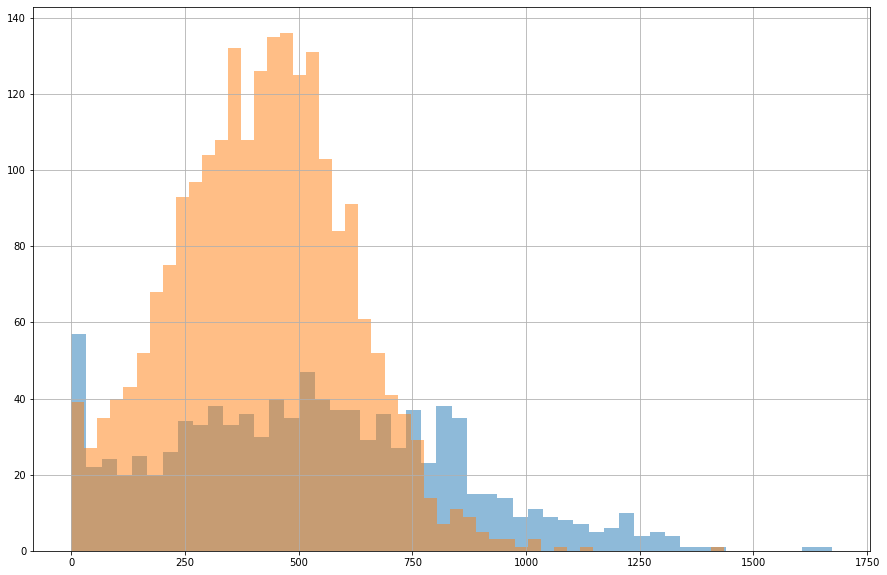

In [26]:
ultra_people['duration'].hist(bins = 50, figsize = (15, 10), alpha = 0.5)
smart_people['duration'].hist(bins = 50, figsize = (15, 10), alpha = 0.5)
plt.show()

Гистограммы подтверждают описанное выше. В обоих случаях гистограммы имеют некоторую скошенность: для тарифа смарт гистограмма плавнее слева, а для ультра - справа. Слева, разумеется, обе гистограммы упираются в 0 - отрицательного значения длительности быть не может. Соответственно, высокое число разговоров около нуля - не следствие очень коротких звонков, а следствие непринятых. Это можно проверить, построив те же гистограммы без неприянтых звонков 

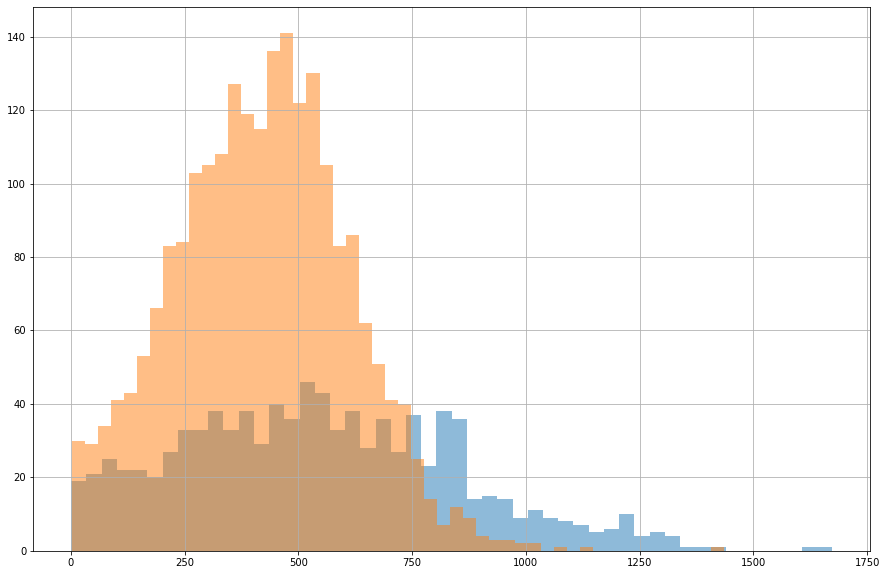

In [27]:
ultra_people.query('duration != 0')['duration'].hist(bins = 50, figsize = (15, 10), alpha = 0.5)
smart_people.query('duration != 0')['duration'].hist(bins = 50, figsize = (15, 10), alpha = 0.5)
plt.show()

Как и следовало ожидать, высокие столбики слева исчезли, остались только действительно существовавшие, но короткие разговоры

### Количество сообщений

In [28]:
print(ultra_people['messages'].describe())
print(smart_people['messages'].describe())
print('Дисперсия для месячного количества сообщений тарифа ultra', np.var(ultra_people['messages']))
print('Дисперсия для месячного количества сообщений тарифа smart', np.var(smart_people['messages']))

count    986.000000
mean      49.313387
std       47.806040
min        0.000000
25%        6.000000
50%       38.000000
75%       78.750000
max      224.000000
Name: messages, dtype: float64
count    2230.000000
mean       33.369058
std        28.230396
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: messages, dtype: float64
Дисперсия для месячного количества сообщений тарифа ultra 2283.0995570851965
Дисперсия для месячного количества сообщений тарифа smart 796.5978766916688


- Для тарифа "Ультра" среднее число сообщений - 49.313387, а для "Смарт" - 33.369058
- Стандартное отклонение для "Ультра" - 47.806040, для "Смарт" - 28.230396, дисперсия - 2283.0995570851965 и 796.5978766916688, соответственно. Как и в случае со звонками, это показывает, что распределение количества сообщений по выборке для тарифа "Смарт" гораздо шире
- В отличие от длительности звонков в случае с сообщениями оба графика скошены вправо - разброс бОльших чем среднее значение довольно большой
- При этом довольно много людей в выборке обоих тарифов отправляет довольно мало сообщений в месяц - первые квартили заканичаются на 6 сообщениях для "Ультра" и 10 для "Смарта". Построим гистограммы.

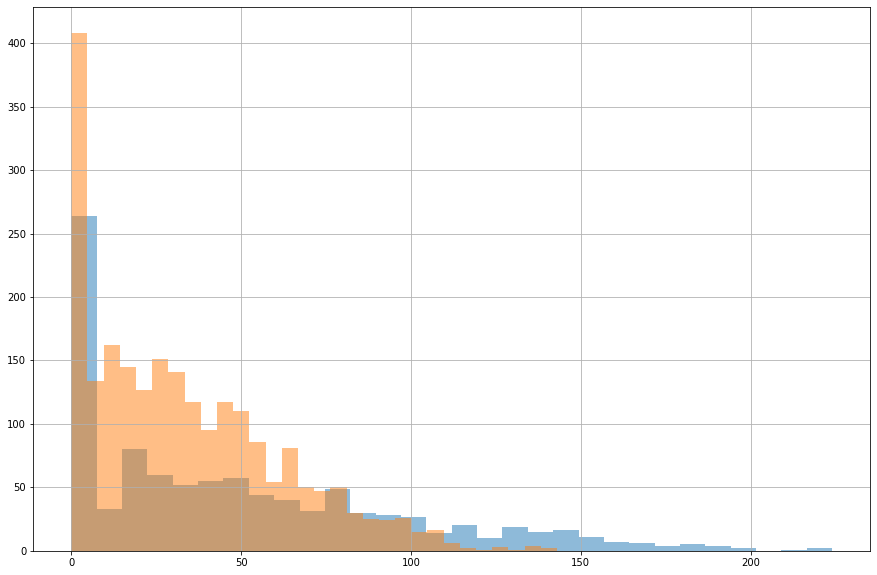

In [29]:
ultra_people['messages'].hist(bins = 30, figsize = (15, 10), alpha = 0.5)
smart_people['messages'].hist(bins = 30, figsize = (15, 10), alpha = 0.5)
plt.show()

Гистограммы отлично иллюстрируют описанное выше. Высокие столбцы слева - это те, кто отправляет мало сообщений или не отправляет их вовсе. Посмотрим на тот же график, убрав нулевые значения и приблизив левую часть

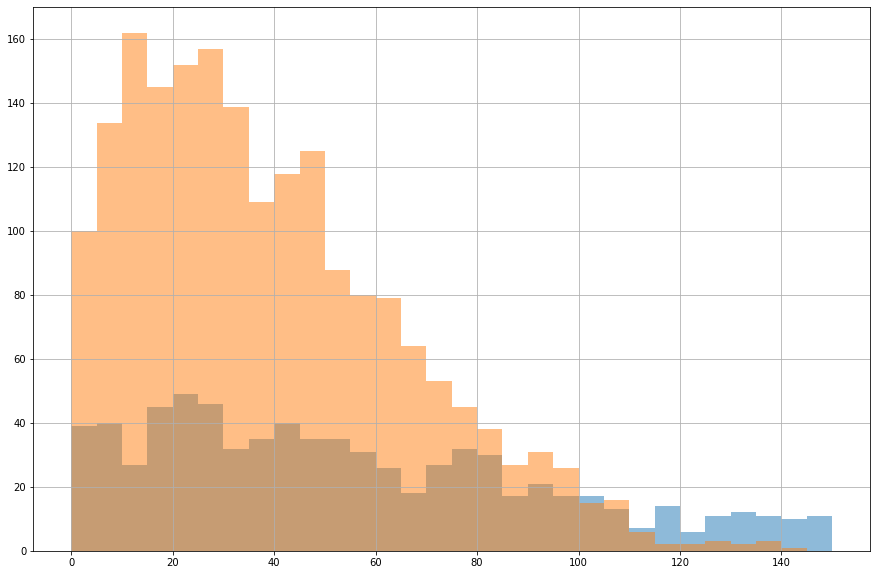

In [30]:
ultra_people.query('messages != 0')['messages'].hist(bins = 30,
                                                     range = (0, 150), figsize = (15, 10), alpha = 0.5)
smart_people.query('messages != 0')['messages'].hist(bins = 30,
                                                     range = (0, 150), figsize = (15, 10), alpha = 0.5)
plt.show()

Без "нулевых" данных, стали четко видны пики тарифа "Смарт" в районе 10 - 30 сообщений в месяц, в то время, как "Ультра" гораздо больше распределен. Это может быть связано с тем, что более дорого тариф используется для каких- то коммерческих рассылок, в то время, как "Смарт" чаще используется для частного пользования.

### Интернет-трафик

In [31]:
print(ultra_people['gb'].describe())
print(smart_people['gb'].describe())
print('Дисперсия для месячного трафика на тарифе ultra', np.var(ultra_people['gb']))
print('Дисперсия для месячного трафика на тарифе smart', np.var(smart_people['gb']))

count    986.000000
mean      19.474645
std        9.868057
min        0.000000
25%       12.000000
50%       19.000000
75%       27.000000
max       49.000000
Name: gb, dtype: float64
count    2230.000000
mean       16.321525
std         5.756167
min         0.000000
25%        13.000000
50%        17.000000
75%        20.000000
max        38.000000
Name: gb, dtype: float64
Дисперсия для месячного трафика на тарифе ultra 97.27978308900676
Дисперсия для месячного трафика на тарифе smart 33.11859498481772


- Пользователи тарифа "Ультра" в выборке в среднем расходуют 19.474645 гб в месяц, в то время как пользователи "Смарт" - 16.321525 гб.
- Стандартное отклонение для "Ультра" - 9.868057, для "Смарт" - 5.756167, дисперсия 97.27978308900676 и 33.11859498481772 соответственно. Как и в случае с минутами и сообщениями, разброс данных на более "старшем" тарифе "Ультра" - почти в 3 раза больше.
- В обоих тарифах среднее не сильно отличается от медианы, но набор данных "Ультра" чуть скошен вправо (в том числе за счет бОльшего разброса значений), а тарифа "Смарт" - влево, его пользователи потребляют в месяц сравнительно меньше трафика. Построим иллюстрирующую это гистограмму, сразу же выделив на ней тех, кто не пользуется мобильным интернетом (т.е. промежуток 0-1 на оси х).

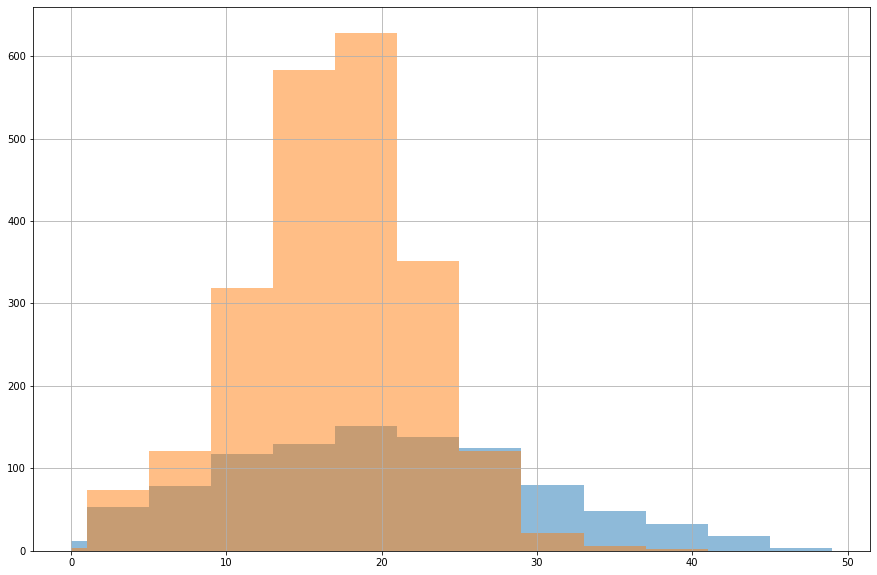

In [32]:
ultra_people['gb'].hist(bins= [0, 1, 5, 9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49], figsize = (15, 10), alpha = 0.5)
smart_people['gb'].hist(bins= [0, 1, 5, 9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49], figsize = (15, 10), alpha = 0.5)
plt.show()

Интересно, что в отличие от звонков и сообщений, данных о месячном потреблении интернета, равном "0" - совсем мало. При этом видны четкие максимумы - на обоих тарифах люди чаще всего потребляют 15 - 25 гб в месяц, хотя на тарифе "Ультра" - в среднем больше.

## Проверка гипотез

### Выручка для пользователей тарифов  "Ультра" и "Смарт"

Сравним среднюю выручку в выборках тарифов. Нулевая гипотеза будет звучать так:
- Средняя выручка пользователей тарифов "Ультра" и "Смарт" равна.

Учитывая то, что абонентская плата в тарифе "Ультра" практически в 4 раза больше, чем в "Смарт", да и разброс данных при анализе количества звонков, сообщений и трафика шире (есть большой "хвост" в большую сторону), альтернативную гипотезу целесообразно сформулировать односторонней:
- Средняя выручка пользователей тарифа "Ультра" больше, чем тарифа "Смарт"

In [33]:
#применим метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам.
#Поскольку выборки у нас разного размера (986 и 2230 строк), поставим equal_var = False.

alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвегнем гипотезу

results_payment = st.ttest_ind(
    ultra_people['payment'], 
    smart_people['payment'], equal_var = False)

#мы проверяем одностороннюю гипотезу, поэтому p-value надо поделить на 2
print('p-значение: ', results_payment.pvalue / 2)

if (results_payment.pvalue / 2 < alpha) and (ultra_people['payment'].mean() > smart_people['payment'].mean()):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  9.635056972104705e-251
Отвергаем нулевую гипотезу


P-значение исчезающе маленькое, можно с уверенностью отвергнуть первоначальную гипотезу о равенстве выручки пользователей тарифов. Подтверждение находит гипотеза, что выручка пользователей тарифа "Ультра" больше.

### Выручка для пользователей тарифов из Москвы и других регионов

Теперь нам надо посмотреть отличается ли средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Сделаем это для каждого тарифа отдельно. Но нулевая и альтернативная гипотезы будут звучать одинаково. Нулевая:
- Средняя выручка пользователей из Москвы и из других регионов равна

Альтернативная:
- Средняя выручка пользователей из Москвы и других регионов не равна (в данном случае гипотеза двухсторонняя)

Начнем с тарифа "Ультра"

In [34]:
#С помощью метода query отдельно сделаем выборки для Москвы и не для Москвы 
#Выборки получатся наверняка разными по размеру, да и дисперсия скорее всего разная. Лучше поставить equal_var = False
results_ultra = st.ttest_ind(ultra_people.query('city == "Москва"')['payment'], 
                             ultra_people.query('city != "Москва"')['payment'], 
                             equal_var = False)

print('p-значение: ', results_ultra.pvalue)

if results_ultra.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.8499417228125278
Не получилось отвергнуть нулевую гипотезу


По имеющимся в выборке данным мы не можем утверждать, что средняя выручка для пользователей тарифа "Ультра" в Москве и дургих регионов отличается. Если построить гистограммы для этих параметров, то они должны в целом повторяться с поправкой на масштаб московской и немосковской выборок

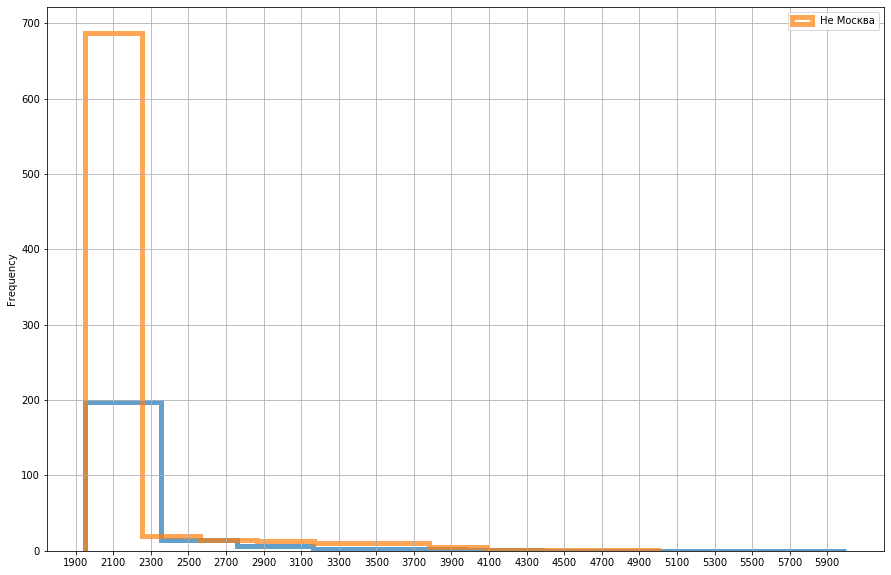

In [35]:
upm = ultra_people.query('city == "Москва"')['payment'].plot(
    kind='hist',
    histtype='step',
    range=(1950, 6000),
    bins=10,
    linewidth=5,
    alpha=0.7,
    label='Москва', 
    figsize = (15, 10))

ultra_people.query('city != "Москва"')['payment'].plot(kind='hist',
    y='time_spent',
    histtype='step',
    range=(1950, 5000),
    xticks = range(1900, 
                   6000, 
                   200), 
    bins=10,                                                
    linewidth=5,
    alpha=0.7,
    label='Не Москва',
    ax=upm,
    grid=True,
    legend=True, figsize = (15, 10))
plt.show()

Да, так и есть. Теперь посмотрим на тариф "Смарт"

p-значение:  0.15741281346674899
Не получилось отвергнуть нулевую гипотезу


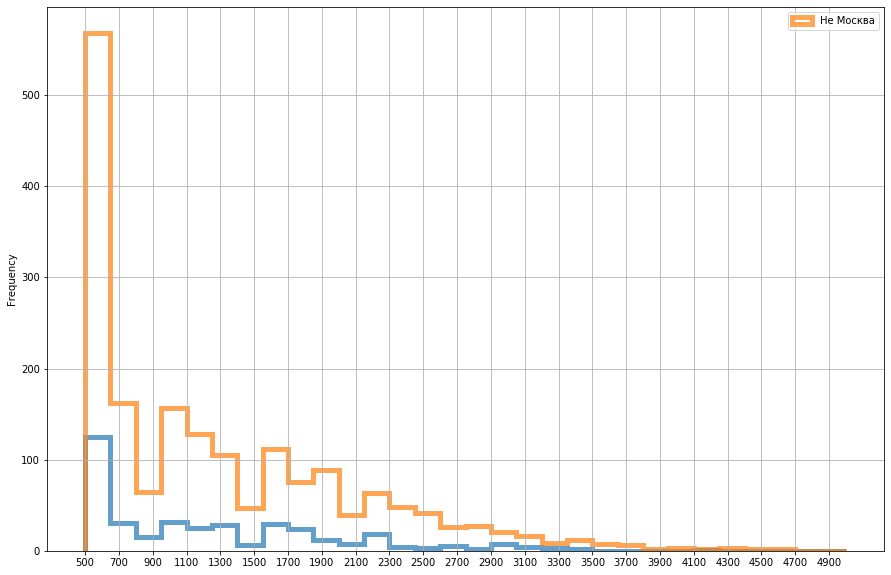

In [36]:
#С помощью метода query отдельно сделаем выборки для Москвы и не для Москвы 
#Выборки получатся наверняка разными по размеру, да и дисперсия скорее всего разная. Лучше поставить equal_var = False
results_smart = st.ttest_ind(smart_people.query('city == "Москва"')['payment'], 
                             smart_people.query('city != "Москва"')['payment'], 
                             equal_var = False)

print('p-значение: ', results_smart.pvalue)

if results_smart.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    
#Сразу построим гистограммы

spm = smart_people.query('city == "Москва"')['payment'].plot(
    kind='hist',
    histtype='step',
    range=(500, 5000),
    bins=30,
    linewidth=5,
    alpha=0.7,
    label='Москва', 
    figsize = (15, 10))

smart_people.query('city != "Москва"')['payment'].plot(kind='hist',
    y='time_spent',
    histtype='step',
    range=(500, 5000),
    xticks = range(500, 
                   5000, 
                   200), 
    bins=30,
    linewidth=5,
    alpha=0.7,
    label='Не Москва',
    ax=spm,
    grid=True,
    legend=True, figsize = (15, 10))
plt.show()

Для тарифа "Смарт" также отвергнуть гипотезу об одинаковой выручке в Москве и других регионах нельзя, хотя, судя по тому, что p-значение гораздо меньше, чем у тарифа "Ультра", разница в отдельных случаях может быть более существенной, чем у "Ультра".

### Выручка для общей выборки

Теперь проверим для всей совокупности. Для начала снова объединим талицы, ведь выручку мы считали уже в таблицах по тарифам.

In [37]:
month_full = ultra_people.merge(smart_people, how = 'outer')
month_full

,user_id,month,duration,calls,messages,gb,tariff,city,minutes_over,messages_over,gb_over,payment
0,1000,5.0,159.0,22.0,22.0,3.0,ultra,Краснодар,0.0,0.0,0.0,1950.0
1,1000,6.0,172.0,43.0,60.0,23.0,ultra,Краснодар,0.0,0.0,0.0,1950.0
2,1000,7.0,340.0,47.0,75.0,14.0,ultra,Краснодар,0.0,0.0,0.0,1950.0
3,1000,8.0,408.0,52.0,81.0,14.0,ultra,Краснодар,0.0,0.0,0.0,1950.0
4,1000,9.0,466.0,58.0,57.0,15.0,ultra,Краснодар,0.0,0.0,0.0,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1489,9.0,0.0,0.0,32.0,17.0,smart,Санкт-Петербург,0.0,0.0,2.0,950.0
3212,1489,10.0,0.0,0.0,21.0,20.0,smart,Санкт-Петербург,0.0,0.0,5.0,1550.0
3213,1489,11.0,0.0,0.0,20.0,18.0,smart,Санкт-Петербург,0.0,0.0,3.0,1150.0
3214,1489,12.0,0.0,0.0,35.0,17.0,smart,Санкт-Петербург,0.0,0.0,2.0,950.0


Нулевая гипотеза по-прежнему:
- Средняя выручка пользователей из Москвы и из других регионов равна

Альтернативная:
- Средняя выручка пользователей из Москвы и других регионов не равна (в данном случае гипотеза двухсторонняя)

p-значение:  0.5216952110000278
Не получилось отвергнуть нулевую гипотезу


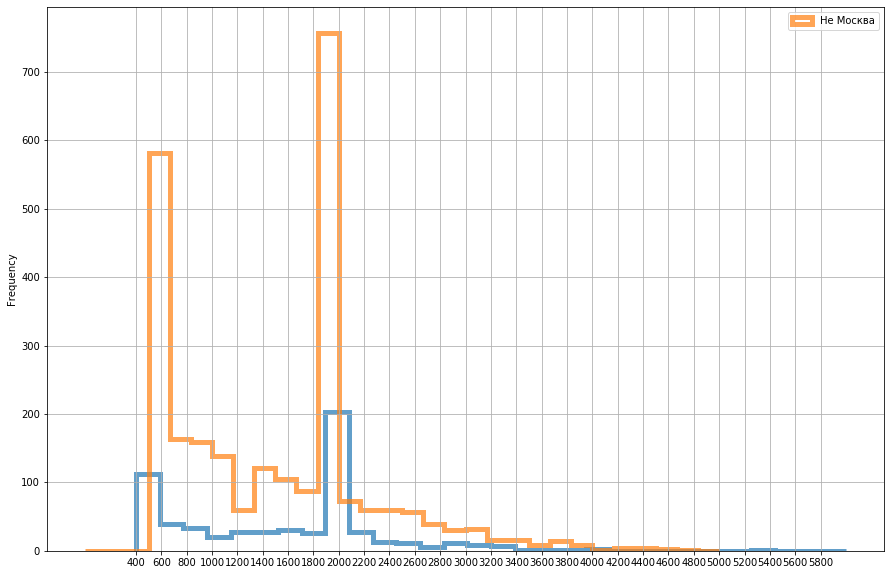

In [40]:
results_all = st.ttest_ind(month_full.query('city == "Москва"')['payment'], 
                             month_full.query('city != "Москва"')['payment'], 
                             equal_var = False)

print('p-значение: ', results_all.pvalue)

if results_all.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

#и сразу построим гистограмму    
apm = month_full.query('city == "Москва"')['payment'].plot(
    kind='hist',
    histtype='step',
    range=(400, 6000),
    bins=30,
    linewidth=5,
    alpha=0.7,
    label='Москва', 
    figsize = (15, 10))

month_full.query('city != "Москва"')['payment'].plot(kind='hist',
    y='time_spent',
    histtype='step',
    range=(0, 5000),
    xticks = range(400, 
                   6000, 
                   200), 
    bins=30,
    linewidth=5,
    alpha=0.7,
    label='Не Москва',
    ax=apm,
    grid=True,
    legend=True, figsize = (15, 10))
plt.show()

Для двух тарифов совокупно, как и для каждого по отдельности, гипотеза о разной выручке в Москве и других регионах не находит подтверждения. На общем графике прекрасно видны пики, равные абонентской плате тарфиов - это те пользователи, которые не превысили лимит.

## Вывод

- Средний пользователь тарифа "Ультра", согласно данным в выборке, в месяц говорит 526 минут, отправляет 49 сообщений и расходует почти 19,5 гб трафика
- Средний пользователь тарифа "Смарт", согласно данным в выборке, в месяц говорит 418 минут, отправляет 33 сообщения и расходует 16,32 гб трафика
- Разброс значений в показателях  тарифа "Ультра" значительно шире, чем для тарифа "Смарт", что определяется и бОльшими лимитами.
- Тем не менее, именно на тарифе "Смарт" пользователи чаще превышают лимиты: показатели для среднего пользователя гораздо ближе к лимитам тарифа, а для интернета - вообще превышают лимит в 15 гб. Таким образом, пользователи "Смарт" гораздо чаще платят сверх абонентской платы
- Несмотря на переплату сверх тарифа для пользователей "Смарт", гипотеза о том, что выручка пользователей "Смарт" и "Ультра" равна, не находит подтверждения. По данным выборки можно сказать, что выручка для пользователя "Ультра" будет все равно больше.
- Гипотеза о том, что выручка для пользователей из Москвы и из других регионов сильно различается, не находит подтверждения, как для совокупности данных по обоим тарифам, так и для тарифов по-отдельности. Вместе с тем p-значение припроверке гипотез о равенстве выручки для пользователей Москвы и не Москвы у тарифа "Смарт" гораздо меньше, чем у "Ультра", т.е. вероятность того, что средняя выручка для пользователей "Смарт" будет различаться - больше. 